In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import sklearn
import sys
import os

### Import to access Tagalog stopwords

In [2]:
!{sys.executable} -m pip install advertools

## Import and prepare CSV files
---

In [3]:
gps_df = pd.read_csv('data/play_store_reviews.csv')
as_df = pd.read_csv('data/app_store_reviews.csv')
combined_df = pd.read_csv('data/combined_reviews.csv')

# convert date columns to datetime since dtypes aren't preserved in csv files
gps_df['at'] = pd.to_datetime(gps_df['at'])
as_df['date'] = pd.to_datetime(as_df['date'])
combined_df['date'] = pd.to_datetime(combined_df['date'])

In [4]:
# drop unnecessary columns
gps_df = gps_df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1)
gps_df.head()

,content,score,at
0,Friendly user.,5,2020-08-05 06:23:06
1,nice and easy,5,2021-05-07 12:10:07
2,Amazing gcash,5,2021-04-11 06:13:37
3,Nice apps ever last thing 🔥🔥🔥🔥🔥😍😍😍😍😍😘😘😘😘😘,5,2021-02-26 01:45:39
4,Very convinience,5,2020-08-02 04:48:25


In [5]:
as_df = as_df.drop(['title', 'userName', 'isEdited', 'developerResponse'], axis=1)
as_df.head()

,date,review,rating
0,2021-02-17 06:32:13,Nakakadismaya naman. Dati okay naman yung gcas...,1
1,2020-03-24 03:28:48,Don’t ever put your money here! My transaction...,1
2,2020-09-15 16:58:57,Best as it has no fees. Wish they had rebates ...,5
3,2020-06-07 09:31:21,Gcash has been very helpful in many ways to me...,1
4,2020-09-25 09:19:47,I USED METROBANK INSTAPAY TO CASH IN BUT UNTIL...,1


In [6]:
combined_df.head()

,date,review,rating
0,2021-02-17 06:32:13,Nakakadismaya naman. Dati okay naman yung gcas...,1
1,2020-03-24 03:28:48,Don’t ever put your money here! My transaction...,1
2,2020-09-15 16:58:57,Best as it has no fees. Wish they had rebates ...,5
3,2020-06-07 09:31:21,Gcash has been very helpful in many ways to me...,1
4,2020-09-25 09:19:47,I USED METROBANK INSTAPAY TO CASH IN BUT UNTIL...,1


### Drop rows that have NULL entries

In [7]:
combined_df = combined_df.dropna()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112266 entries, 0 to 112274
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    112266 non-null  datetime64[ns]
 1   review  112266 non-null  object        
 2   rating  112266 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.4+ MB


In [8]:
gps_df = gps_df.dropna()
gps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110597 entries, 0 to 110605
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   content  110597 non-null  object        
 1   score    110597 non-null  int64         
 2   at       110597 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.4+ MB


## Plain text to bag-of-words (BOW)
---

In [9]:
import re
import nltk
import advertools as adv
from nltk import word_tokenize          
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# concatenate english and tagalog stopwords into one list
stop_words = stopwords.words('english') + list(adv.stopwords['tagalog'])

token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize and lemmatize review data

In [10]:
import time
from sklearn.feature_extraction.text import CountVectorizer

data = []
data = as_df.review.values.tolist()
vocab_size = 1000

print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(
    input='content', 
    analyzer='word', 
    stop_words=stop_words,
    tokenizer=LemmaTokenizer(), 
    max_features=vocab_size, 
    max_df=0.95, 
    min_df=2
)

vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 1000
Done. Time elapsed: 3.15s


### Remove reviews shorter than three words
Very short reviews won't be able to express more than a single topic

In [119]:
print(f'Before:\n{vectors.shape}')

threshold = 25
vectors = vectors[np.array(vectors.sum(axis=1)>threshold).reshape(-1,)]
print(f'\nAfter removing short reviews (<{threshold} words):')        
print(vectors.shape)

print(f'\n{type(vectors), vectors.dtype}')
print(vectors[0])

Before:
(1479, 1000)

After removing short reviews (<3 words):
(1479, 1000)

(<class 'scipy.sparse.csr.csr_matrix'>, dtype('float32'))
  (0, 998)	1.0
  (0, 317)	1.0
  (0, 209)	1.0
  (0, 901)	1.0
  (0, 183)	1.0
  (0, 775)	1.0
  (0, 40)	1.0
  (0, 545)	2.0
  (0, 630)	1.0
  (0, 426)	1.0
  (0, 262)	1.0
  (0, 531)	1.0
  (0, 491)	1.0
  (0, 240)	1.0
  (0, 585)	1.0
  (0, 387)	1.0
  (0, 16)	3.0
  (0, 170)	1.0
  (0, 185)	1.0
  (0, 615)	1.0
  (0, 554)	2.0
  (0, 552)	1.0
  (0, 45)	1.0


In [120]:
vectors[0].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### Type-cast input dat to np.float32 since all the params (i.e. weights and biases) in the NTM model will also follow that format
This is a more optimal approach as opposed to repeatedly type-casting during mini-batch training

In [121]:
import scipy.sparse as sparse

vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)
print(vectors[0])

<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 998)	1.0
  (0, 317)	1.0
  (0, 209)	1.0
  (0, 901)	1.0
  (0, 183)	1.0
  (0, 775)	1.0
  (0, 40)	1.0
  (0, 545)	2.0
  (0, 630)	1.0
  (0, 426)	1.0
  (0, 262)	1.0
  (0, 531)	1.0
  (0, 491)	1.0
  (0, 240)	1.0
  (0, 585)	1.0
  (0, 387)	1.0
  (0, 16)	3.0
  (0, 170)	1.0
  (0, 185)	1.0
  (0, 615)	1.0
  (0, 554)	2.0
  (0, 552)	1.0
  (0, 45)	1.0


In [122]:
vectors[0].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### Split data to training (20%), validation (40%), and test (40%) datasets

In [123]:
n_train = int(0.2 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(295, 1000) (592, 1000) (592, 1000)


### Store data in S3

In [16]:
# import os
# from sagemaker import get_execution_role

# role = get_execution_role()

# bucket = 'sagemaker-us-east-1-305262579855'
# prefix = 'sagemaker/regalado'

# train_prefix = os.path.join(prefix, 'train')
# valid_prefix = os.path.join(prefix, 'valid')
# output_prefix = os.path.join(prefix, 'output')

# s3_train_data = os.path.join('s3://', bucket, train_prefix)
# s3_valid_data = os.path.join('s3://', bucket, valid_prefix)
# output_path = os.path.join('s3://', bucket, output_prefix)
# print('Training set location', s3_train_data)
# print('Validation set location', s3_valid_data)
# print('\nTrained model will be saved at', output_path)

### Convert data into RecordIO Protobuf format using the SageMaker Python API

In [17]:
import scipy

# convert sparse CSR matrices to numpy arrays
train_vectors = scipy.sparse.csr_matrix.toarray(train_vectors)
val_vectors = scipy.sparse.csr_matrix.toarray(val_vectors)
test_vectors = scipy.sparse.csr_matrix.toarray(test_vectors)

In [29]:
import io
import boto3
import sagemaker
import datetime as dt
import sagemaker.amazon.common as smac

sesh = sagemaker.Session()
prefix = "sagemaker/regalado"
bucket = sesh.default_bucket()
curr_dtime = time.strftime("%Y%m%d-%H%M%S")

def convAndStore(dtype, key, vectors):
    # convert data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms
    
    # init memory buffer in RAM where data will be written
    buf = io.BytesIO()

    # write train data (numpy array) into a dense tensor 
    # smac.write_numpy_to_dense_tensor(buf, X_train.astype("float32"), y_train.astype("float32"))
    smac.write_numpy_to_dense_tensor(buf, vectors)

    # sets the file's current position at the offset (0)
    # i.e. set the reference point to the beginning of the memory buffer
    buf.seek(0)
    
    # upload to s3
    key = str(key)
    

    boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, dtype, key)).upload_fileobj(buf)
    s3_data = f"s3://{bucket}/{prefix}/{dtype}/{key}"
    
    print(f"Uploaded data at: {s3_data}")
    
    return s3_data
    
s3_train_data = convAndStore('train', curr_dtime, train_vectors)
s3_valid_data = convAndStore('valid', curr_dtime, val_vectors)
s3_test_data = convAndStore('test', curr_dtime, test_vectors)

Uploaded data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/train/20210616-142019
Uploaded data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/valid/20210616-142019
Uploaded data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/test/20210616-142019


### Store data in S3

In [ ]:
# import os
# import boto3

# def tos3(key, buf):
#     key = str(key)
#     prefix = "regalado"

#     boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
#     s3_data = f"s3://{bucket}/{prefix}/train/{key}"

#     print(f"Uploaded data at: {s3_data}")

# # convert data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms
# # then upload to s3
# tos3('train', toProtobuf(train_vectors))

### Convert data into RecordIO Protobuf format using the SageMaker Python API

In [ ]:
# !pip install -U sagemaker

In [ ]:
# import io
# import boto3
# import sagemaker
# import sagemaker.amazon.common as smac

# def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
#     chunk_size = sparray.shape[0]// n_parts
    
#     for i in range(n_parts):
#         # Calculate start and end indices
#         start = i*chunk_size
#         end = (i+1)*chunk_size
#         if i+1 == n_parts:
#             end = sparray.shape[0]
        
#         # Convert to record protobuf
#         buf = io.BytesIO()
#         smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
#         buf.seek(0)
        
#         # Upload to s3 location specified by bucket and prefix
#         fname = os.path.join(prefix, fname_template.format(i))
#         boto3.resource("s3").Bucket(bucket).Object(fname).upload_fileobj(buf)
#         print("Uploaded data to s3://{}".format(os.path.join(bucket, fname)))

In [ ]:
# split_convert_upload(
#     train_vectors, bucket=bucket, prefix=train_prefix, fname_template="train_part{}.pbr", n_parts=8
# )
# split_convert_upload(
#     val_vectors, bucket=bucket, prefix=valid_prefix, fname_template="val_part{}.pbr", n_parts=1
# )

## Model training
---

### Set credentials

In [34]:
from sagemaker import tuner
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve

sesh = sagemaker.Session()
role = get_execution_role()
container = retrieve('ntm', region)
region = boto3.Session().region_name    
client = boto3.Session().client('sagemaker')
output_prefix = os.path.join(prefix, 'output')
output_path = os.path.join('s3://', bucket, output_prefix)

2021-06-16 14:22:21,677 | INFO | image_uris.py:162 | _config_for_framework_and_scope | Same images used for training and inference. Defaulting to image scope: inference.
2021-06-16 14:22:21,677 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: 1.
2021-06-16 14:22:21,691 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.


In [31]:
!pip install 'sagemaker[local]' --upgrade

In [35]:
!sudo service docker restart

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


In [36]:
ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.c4.xlarge', # Free-tier instance
    output_path=output_path,
    sagemaker_session=sesh
)

In [37]:
num_topics = 20

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    tolerance=0.001,
#     mini_batch_size=128,
#     learning_rate=1e-4
)

In [652]:
ntm.fit(inputs={'train': s3_train_data, 'validation': s3_valid_data})

2021-06-16 12:45:30,243 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-16 12:45:30,255 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-16 12:45:30,257 | INFO | session.py:570 | train | Creating training-job with name: ntm-2021-06-16-12-45-30-242


2021-06-16 12:45:30 Starting - Starting the training job...
2021-06-16 12:45:54 Starting - Launching requested ML instancesProfilerReport-1623847530: InProgress
......
2021-06-16 12:46:54 Starting - Preparing the instances for training.........
2021-06-16 12:48:15 Downloading - Downloading input data......
2021-06-16 12:49:30 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/16/2021 12:49:35 INFO 140408439797568] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_la

## Automatic Hyperparameter Tuning
---

In [38]:
hyperparameter_ranges = {
    'learning_rate': tuner.ContinuousParameter(1e-4, 0.1),
    'mini_batch_size': tuner.IntegerParameter(16, 2048)
}

objective_metric_name = 'validation:total_loss'

In [39]:
hyperparameter_tuner = tuner.HyperparameterTuner(
    ntm,
    objective_metric_name,
    hyperparameter_ranges, 
    objective_type='Minimize',
    max_jobs=12,
    max_parallel_jobs=3
)

In [40]:
hyperparameter_tuner.fit(
    {'train': s3_train_data, 'validation': s3_valid_data},
    include_cls_metadata=False,
    wait=False
)

job_name = hyperparameter_tuner.latest_tuning_job.job_name

response = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name
)

response['HyperParameterTuningJobStatus']

2021-06-16 14:22:40,641 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-16 14:22:40,664 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-16 14:22:40,667 | INFO | session.py:2050 | create_tuning_job | Creating hyperparameter tuning job with name: ntm-210616-1422


'InProgress'

In [41]:
from pprint import pprint

pprint(response)

{'CreationTime': datetime.datetime(2021, 6, 16, 14, 22, 41, 955000, tzinfo=tzlocal()),
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:305262579855:hyper-parameter-tuning-job/ntm-210616-1422',
 'HyperParameterTuningJobConfig': {'HyperParameterTuningJobObjective': {'MetricName': 'validation:total_loss',
                                                                        'Type': 'Minimize'},
                                   'ParameterRanges': {'CategoricalParameterRanges': [],
                                                       'ContinuousParameterRanges': [{'MaxValue': '0.1',
                                                                                      'MinValue': '0.0001',
                                                                                      'Name': 'learning_rate',
                                                                                      'ScalingType': 'Auto'}],
                                                       'IntegerPara

In [42]:
hyperparameter_tuner.__dict__

{'estimator': <sagemaker.estimator.Estimator at 0x7fe2cee28e10>,
 'objective_metric_name': 'validation:total_loss',
 '_hyperparameter_ranges': {'learning_rate': <sagemaker.parameter.ContinuousParameter at 0x7fe2cee28e48>,
  'mini_batch_size': <sagemaker.parameter.IntegerParameter at 0x7fe2f01100b8>},
 'metric_definitions': None,
 'estimator_dict': None,
 'objective_metric_name_dict': None,
 '_hyperparameter_ranges_dict': None,
 'metric_definitions_dict': None,
 'static_hyperparameters_dict': None,
 'strategy': 'Bayesian',
 'objective_type': 'Minimize',
 'max_jobs': 12,
 'max_parallel_jobs': 3,
 'tags': None,
 'base_tuning_job_name': None,
 '_current_job_name': 'ntm-210616-1422',
 'latest_tuning_job': <sagemaker.tuner._TuningJob at 0x7fe2c3c50b38>,
 'warm_start_config': None,
 'early_stopping_type': 'Off',
 'static_hyperparameters': {'num_topics': '20',
  'feature_dim': '1000',
  'epochs': '100',
  'num_patience_epochs': '5',
  'tolerance': '0.001'}}

In [43]:
tuning_job_name = response['HyperParameterTuningJobName']
%store tuning_job_name

tuning_job_name

Stored 'tuning_job_name' (str)


'ntm-210616-1422'

In [44]:
from time import sleep

while response['HyperParameterTuningJobStatus'] == 'InProgress':
    response = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )

    print(response['HyperParameterTuningJobStatus'])
    sleep(60)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [45]:
%store -r tuning_job_name

from sagemaker import HyperparameterTuningJobAnalytics

def latest_df():
    analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

    return analytics.dataframe()    

latest_df().sort_values('FinalObjectiveValue', ascending=True)

,learning_rate,mini_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,0.001661,2048.0,ntm-210616-1422-009-ec3d0a59,Completed,1.827043,2021-06-16 14:34:44+00:00,2021-06-16 14:35:54+00:00,70.0
5,0.001537,2048.0,ntm-210616-1422-007-ca8a0bef,Completed,1.827043,2021-06-16 14:34:31+00:00,2021-06-16 14:35:52+00:00,81.0
4,0.000149,2047.0,ntm-210616-1422-008-791e8e33,Completed,1.827936,2021-06-16 14:34:12+00:00,2021-06-16 14:35:21+00:00,69.0
2,0.000401,1929.0,ntm-210616-1422-010-dbf5eda8,Completed,1.939753,2021-06-16 14:38:36+00:00,2021-06-16 14:39:19+00:00,43.0
0,0.000102,1922.0,ntm-210616-1422-012-95ca4d2c,Completed,1.946818,2021-06-16 14:38:47+00:00,2021-06-16 14:40:06+00:00,79.0
1,0.000100,1881.0,ntm-210616-1422-011-ceac53d5,Completed,1.989253,2021-06-16 14:38:43+00:00,2021-06-16 14:39:54+00:00,71.0
6,0.014783,1526.0,ntm-210616-1422-006-1634415a,Completed,2.451354,2021-06-16 14:29:50+00:00,2021-06-16 14:30:56+00:00,66.0
8,0.001542,865.0,ntm-210616-1422-004-88d5e9f1,Completed,4.324584,2021-06-16 14:29:37+00:00,2021-06-16 14:30:53+00:00,76.0
7,0.001428,823.0,ntm-210616-1422-005-f7e1627a,Completed,4.545280,2021-06-16 14:29:12+00:00,2021-06-16 14:31:08+00:00,116.0
11,0.002710,729.0,ntm-210616-1422-001-f2b794fe,Completed,5.131366,2021-06-16 14:25:14+00:00,2021-06-16 14:26:30+00:00,76.0


### Specify how training and validation data will be distributed to the workers during training
ShardedByS3Key: data files will be sharded to different workers, that is, each worker will receive a different portion of the full data set.

In [651]:
# from sagemaker.inputs import TrainingInput

# s3_train = TrainingInput(s3_train_data, distribution="ShardedByS3Key") 
# s3_valid = TrainingInput(s3_valid_data) 

In [48]:
import sagemaker

sesh = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.c4.xlarge', # Free-tier instance
    output_path=output_path,
    sagemaker_session=sesh
)

num_topics = 10

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    tolerance=0.001,
    mini_batch_size=2048,
    learning_rate=0.001661
)

In [49]:
ntm.fit(inputs={"train": s3_train_data, "validation": s3_valid_data})

2021-06-16 14:48:35,619 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-16 14:48:35,893 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-16 14:48:35,894 | INFO | session.py:570 | train | Creating training-job with name: ntm-2021-06-16-14-48-35-617


2021-06-16 14:48:36 Starting - Starting the training job...
2021-06-16 14:49:00 Starting - Launching requested ML instancesProfilerReport-1623854915: InProgress
......
2021-06-16 14:50:01 Starting - Preparing the instances for training......
2021-06-16 14:51:01 Downloading - Downloading input data...
2021-06-16 14:51:24 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/16/2021 14:51:47 INFO 140398883272512] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation': 'sigmoid', 'o

In [100]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

2021-06-16 15:20:10,547 | INFO | session.py:2552 | create_model | Creating model with name: ntm-2021-06-16-15-20-10-471
2021-06-16 15:20:11,213 | INFO | session.py:2973 | create_endpoint | Creating endpoint with name ntm-2021-06-16-15-20-10-471


----------------!

In [124]:
test_vectors[:5]

<5x1000 sparse matrix of type '<class 'numpy.float32'>'
	with 35 stored elements in Compressed Sparse Row format>

In [127]:
def recordio_protobuf_serializer(spmatrix):
    import io
    import sagemaker.amazon.common as smac

    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(array=spmatrix, file=buf, labels=None)
    buf.seek(0)
    return buf

test = recordio_protobuf_serializer(test_vectors[:5])

In [144]:
asd = '''0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.'''

asd = str.encode(asd)
asd

b'0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n         0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [146]:
# test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(asd)
print(results)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from model with message "content-type application/octet-stream not supported". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/ntm-2021-06-16-15-20-10-471 in account 305262579855 for more information.

In [151]:
from sagemaker.serializers import CSVSerializer, JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# ntm_predictor.content_types = 'text/csv'
ntm_predictor.serializers = CSVSerializer
ntm_predictor.deserializers = JSONDeserializer

# test_data = np.array(test_vectors.todense())
# # test_data = test_vectors
# test = str.encode(str(test_data[0]))

temp = '0.5531491564, 1.9234457948, -0.5482002982, -1.1234940332, -0.7746149700, -2.0820987032, 0.2428820132'

sample_body = str.encode(temp)

results = ntm_predictor.predict(sample_body)
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from model with message "content-type application/octet-stream not supported". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/ntm-2021-06-16-15-20-10-471 in account 305262579855 for more information.

In [155]:
test_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [175]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = sagemaker.predictor.Predictor(
    endpoint_name='ntm-2021-06-16-15-20-10-471', 
    sagemaker_session=sesh, 
    serializer=CSVSerializer(), 
    deserializer=JSONDeserializer()
)

# test_vectors = scipy.sparse.csr_matrix.toarray(test_vectors)

results = predictor.predict(test_vectors[:5])
print(results)

{'predictions': [{'topic_weights': [0.1052153632, 0.102220282, 0.0979740992, 0.1015896797, 0.0979276747, 0.0974645615, 0.0949951783, 0.0989791229, 0.098509796, 0.1051242128]}, {'topic_weights': [0.1054650173, 0.1021495834, 0.0979689881, 0.1016485989, 0.0979238674, 0.097419396, 0.0948564261, 0.0988450646, 0.0984589607, 0.1052642018]}, {'topic_weights': [0.1049652249, 0.1021356881, 0.0979046449, 0.1016638204, 0.0978714228, 0.0976736546, 0.0951751247, 0.0990412906, 0.0985023901, 0.1050667763]}, {'topic_weights': [0.1056258827, 0.1022004411, 0.0980159715, 0.1016122103, 0.0979031846, 0.0973943174, 0.0946930796, 0.0988862514, 0.0984104574, 0.1052581668]}, {'topic_weights': [0.1055426747, 0.1021223217, 0.0979779139, 0.1015704125, 0.0979606658, 0.0974123925, 0.0947961733, 0.0989360958, 0.098379679, 0.1053017378]}]}


In [205]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

2021-06-16 16:02:34,441 | INFO | session.py:3023 | delete_endpoint | Deleting endpoint with name: ntm-2021-06-16-15-20-10-471


In [186]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.10521536 0.10222028 0.0979741  0.10158968 0.09792767 0.09746456
  0.09499518 0.09897912 0.0985098  0.10512421]
 [0.10546502 0.10214958 0.09796899 0.1016486  0.09792387 0.0974194
  0.09485643 0.09884506 0.09845896 0.1052642 ]
 [0.10496522 0.10213569 0.09790464 0.10166382 0.09787142 0.09767365
  0.09517512 0.09904129 0.09850239 0.10506678]
 [0.10562588 0.10220044 0.09801597 0.10161221 0.09790318 0.09739432
  0.09469308 0.09888625 0.09841046 0.10525817]
 [0.10554267 0.10212232 0.09797791 0.10157041 0.09796067 0.09741239
  0.09479617 0.0989361  0.09837968 0.10530174]]


Text(0.5, 0, 'Topic ID')

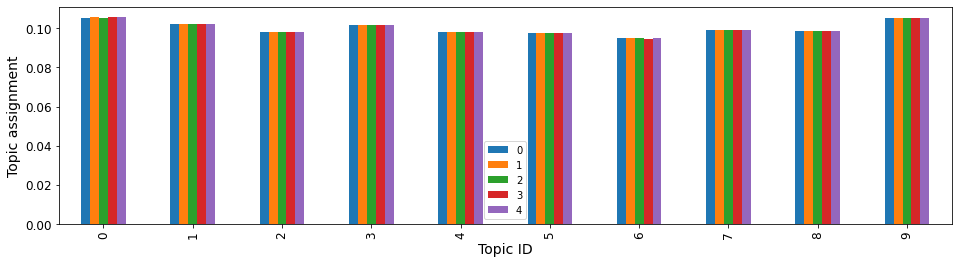

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

In [194]:
# !pip install mxnet
import mxnet as mx

In [195]:
model_path = os.path.join(output_prefix, ntm._current_job_name, "output/model.tar.gz")
model_path

'sagemaker/regalado/output/ntm-2021-06-16-14-48-35-617/output/model.tar.gz'

In [196]:
boto3.resource("s3").Bucket(bucket).download_file(model_path, "downloaded_model.tar.gz")

In [197]:
!pwd

/home/ec2-user/SageMaker/my-experiments


In [198]:
import tarfile
tarfile.open('downloaded_model.tar.gz').extractall()

In [199]:
import zipfile
with zipfile.ZipFile('model_algo-1', 'r') as zip_ref:
    zip_ref.extractall('./')

In [200]:
model = mx.ndarray.load("params")
W = model["arg:projection_weight"]

In [203]:
# !pip install wordcloud
import wordcloud as wc

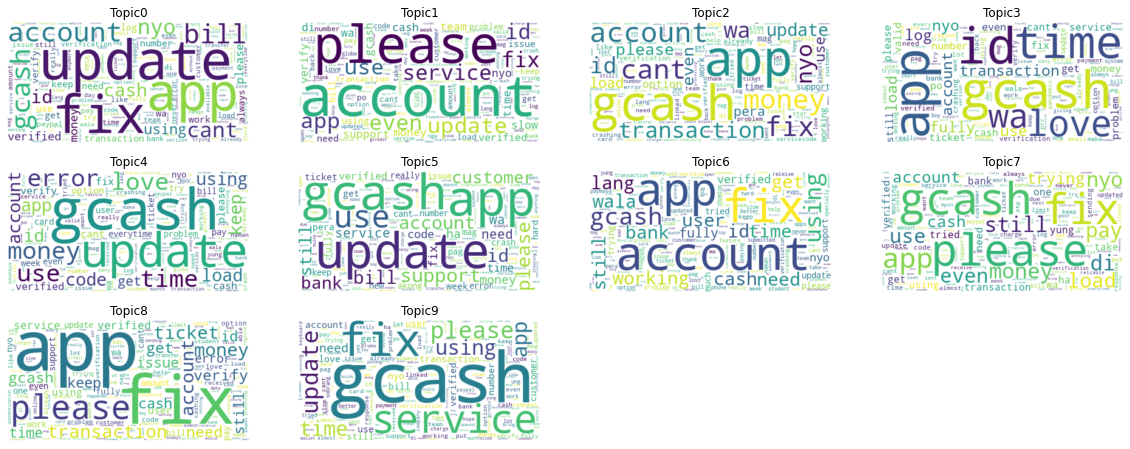

In [204]:
import matplotlib.pyplot as plt
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20, 16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = "Topic{}".format(ind)

    # pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)
    # plt.close()

    counter += 1